In [1]:
import requests
import csv
import re
import pandas as pd
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

# What to buy?
## Analyzing rental properties for investment in Baltimore
### Roxanne Bublitz
### Yuanjing Han
### Jingning Li
### Rongchu Zhao

# Pulling For Sale and Rental Data with Web Scraping

Trulia.com's rental search results presented in a list conducive to web scraping. Baltimore was searched, and then large apartment complexes excluded. Due to the vague pricing (typically a range without specific unit attributes), data from those units could not be collected in a useful way. Some manual monitoring was required if the program stalled. The script prints out the search pages as it scapes so it we be re-run starting at the next page. 

Results are saved in a csv file to be used in other analysis and across into the R interface. 

In [ ]:
def rental_scrape():
    base='https://www.trulia.com/for_rent/Baltimore,MD/SINGLE-FAMILY_HOME,APARTMENT%7CCONDO%7CTOWNHOUSE%7CMULTI-FAMILY%7CLOFT_type'
    for i in range(0,1000):
        data=requests.get(base+'/'+str(i)+'_p')
        soup=bs(data.content, "lxml")
        results_data=soup.find_all('li',{'class':'hover propertyCard property-data-elem clickable'})
        if results_data==[]:
            break
        with open('rentals4.csv', 'a') as csv_file:
            writer = csv.writer(csv_file)
            for item in results_data:
                try:
                    street_address_base=item.find_all("span",{'itemprop': 'streetAddress'})[0].text
                    street_address=street_address_base.replace(',',' ')
                except:
                    street_address='N/A'
                try:
                    city=item.find_all("span",{'itemprop': 'addressLocality'})[0].text
                except:
                    city='N/A'
                try:
                    zipcode=item.find_all("span",{'itemprop': 'postalCode'})[0].text
                except:
                    zipcode='N/A'
                try:
                    price_base=item.find_all("span",{'class': 'typeEmphasize'})[0].text
                    price=price_base.replace(',','').replace('$','')
                except:
                    price='N/A'
                try:
                    bed_bath=item.find_all("div",{'class': 'col cols3'})[0].text
                    bedrooms=bed_bath.split("\n")[1].split(" ")[0]
                    baths=bed_bath.split("\n")[2].split(" ")[0]
                except:
                    bedrooms='N/A'
                    baths='N/A'
                try:
                    latitude=item.find_all("meta",{'itemprop': 'latitude'})[0]['content']
                except:
                    latitude='N/A'
                try:
                    longitude=item.find_all("meta",{'itemprop': 'longitude'})[0]['content']
                except:
                    longitude='N/A'
                sqft_base=item.find_all("div",{'class': 'col cols4 '})[0].text
                sqft_regex=re.compile(r'(\d+)\s(sqft)')
                type_regex=re.compile(r'townhouse|rental|house')
                try:
                    sqft=sqft_regex.search(sqft_base).group(1)
                except:
                    sqft="N/A"
                try:
                    unittype=type_regex.search(sqft_base).group()
                except:
                    unittype="N/A"
                writer.writerow([street_address,city,zipcode,price,bedrooms,baths,latitude,longitude,sqft,unittype])
        print('pg ',i)

We faced difficulty in finding a site to pull house sale information, as many sites default to a map view after searching that displays little information on the specific property on the results page. URLs for individual listings were unique and could not be interated through. Homes.com was found to work, but some information, such as SQFT was often missing. Regex had to be used to pull information from blocks of text within the same HTML tag.

Although not listed on the page, in the HTML was the latitude and longitude, which was scraped for potential mapping applications.

In [ ]:
def sale_scrape():
    base='http://www.homes.com/for-sale/baltimore-md/'
    for i in range(1,1000):
        if i ==1:
            data=requests.get(base)
        else:
            data=requests.get(base+'p'+str(i))
        soup=bs(data.content, "lxml")
        results_data=soup.find_all('div',{'class': 'result-list _listing-result'})
        if results_data==[]:
            break
        with open('forsale.csv', 'a') as csv_file:
            writer = csv.writer(csv_file)
            for item in results_data:
                try:
                    address=item.find_all("span",{'itemprop': 'streetAddress'})[0].text
                except:
                    address="N/A"
                try:
                    locality=item.find_all("span",{'itemprop': 'addressLocality'})[0].text
                except:
                    locality="N/A"
                try:
                    state=item.find_all("span",{'itemprop': 'addressRegion'})[0].text
                except:
                    state='N/A'
                try:
                    zipcode=item.find_all("span",{'itemprop': 'postalCode'})[0].text
                except:
                    zipcode='N/A'
                try:
                    latitude=item.find_all("meta",{'itemprop': 'latitude'})[0]['content'].strip()
                    longitude=item.find_all("meta",{'itemprop': 'longitude'})[0]['content'].strip()
                except:
                    latitude='N/A'
                    longitude='N/A'
                try:
                    price=item.find_all("div",{'class':'result-price'})[0].text.strip().replace('$','').replace(',','')
                except:
                    price='N/A'
                sqft_regex=re.compile(r'(Sqft:)\s(.*)')
                beds_regex=re.compile(r'(Beds:)\s(.*)')
                bathfull_regex=re.compile(r'(\d)\s(full)')
                bathhalf_regex=re.compile(r'(\d)\s(half)')
                lot_regex=re.compile(r'(Size:)\s(\S*)')
                year_regex=re.compile(r'(Built:)\s(\S*)')
                attribute_list=item.find_all("div", {'class':'m'})[0].text
                try:
                    sqft_raw=sqft_regex.search(attribute_list).group(2)
                    sqft=sqft_raw.replace(',','').replace("--","N/A")
                except:
                    sqft="N/A"
                try:
                    beds=beds_regex.search(attribute_list).group(2)
                except:
                    beds="N/A"
                try:
                    bathfull=int(bathfull_regex.search(attribute_list).group(1))
                    try:
                        bathhalf=int(bathhalf_regex.search(attribute_list).group(1))
                    except:
                        bathhalf=0
                    baths=bathfull+(.5*bathhalf)
                except:
                    baths="N/A"
                try:
                    lot_acres_raw=lot_regex.search(attribute_list).group(2)
                    lot_acres=lot_acres_raw.replace("--","N/A")
                except:
                    lot_acres="N/A"
                try:
                    year_built=year_regex.search(attribute_list).group(2)
                except:
                    year_built="N/A"
                writer.writerow([address,locality,state,zipcode,latitude,longitude,price,sqft,beds,baths,lot_acres,year_built])
        print('pg.',i)

# Pulling into Data Frames

We then read the csv into data frames for varible exploration. One issue was discovered that price was showing as string, since some prices had '+' at the end. This was transformed into numeric. 

In [2]:
rent_df=pd.read_csv("rentals3.csv",names=['street_address','city','zipcode','price','bedrooms','baths','latitude','longitude','sqft','unittype'])
sale_df=pd.read_csv("forsale.csv",names=['address','locality','state','zipcode','latitude','longitude','price','sqft','beds','baths','lot_acres','year_built'])
sale_df['price']=pd.to_numeric(sale_df['price'],errors='coerce')
sale_df['beds']=pd.to_numeric(sale_df['beds'],errors='coerce')

Wanting to focus only on Baltmore city, we filtered out properties outside of the city

In [3]:
balt_city_zips=['21203','21215','21209','21210','21212','21239','21214','21234','21236','21207','21216','21217','21211','21218','21251','21206','21213','21228','21229','21223','21201','21202','21231','21287','21205','21237','21227','21230','21231','21224','21222','21225','21226']
city_zips=[]
for i in balt_city_zips:
    city_zips.append(int(i))
#filtering the results to only include zips found in Baltimore City
city_filter_sale=sale_df[sale_df['zipcode'].isin(city_zips)]
city_filter_rent=rent_df[rent_df['zipcode'].isin(city_zips)]

In [26]:
city_filter_sale.head()

,address,locality,state,zipcode,latitude,longitude,price,sqft,beds,baths,lot_acres,year_built
0,1530 Greendale Road,Baltimore,MD,21218,39.336970,-76.592360,138900.0,NaN,3.0,2.0,NaN,1951
1,408 Parrish Street South,Baltimore,MD,21223,39.282890,-76.641520,49900.0,NaN,2.0,1.0,NaN,1915
2,9 Midvale Rd,Baltimore,MD,21210,39.355020,-76.639060,825000.0,NaN,5.0,4.0,0.46,1907
4,9202 Teakwood Rd,Baltimore,MD,21234,39.408375,-76.532288,184900.0,NaN,3.0,2.5,0.05,1983
5,4213 Powell Avenue,Baltimore,MD,21206,39.346730,-76.537240,139900.0,1668.0,3.0,2.0,0.15,1920


In [ ]:
city_filter_rent.head()

In [ ]:
city_filter_rent.count()

In [ ]:
city_filter_sale.count()

# Mapping for Data Exploration

In [4]:
import folium
from folium.plugins import MarkerCluster

 We started with a visualization of the distribution of properties across the city, potentially identifying a hot rental area. 

In [5]:
latitudes=[]
longitudes=[]
prices=[]
for index, row in city_filter_rent.iterrows():
    latitudes.append(row['latitude'])
    longitudes.append(row['longitude'])
    prices.append(row['price'])

### Geographic Rental Clusters

In [ ]:
coors=zip(latitudes,longitudes)
coords=list(coors)
map_object2 = folium.Map(location=[39.29, -76.61], zoom_start=12,tiles='Cartodb Positron')
map_object2.add_children(MarkerCluster(locations=coords, popups=coords))
map_object2

## Visualizing Price Difference

To get an idea of pricing of properties, we wanted to map the properties on a color scale by price. Realizing that prices varied by bedrooms, we used 3 bedroom properies, the rental property number of bedrooms we have the most data for. 

In [28]:
city_filter_rent['bedrooms'].groupby(city_filter_rent['bedrooms']).count()

bedrooms
1.0    281
2.0    670
3.0    790
4.0    168
5.0     34
6.0      4
Name: bedrooms, dtype: int64

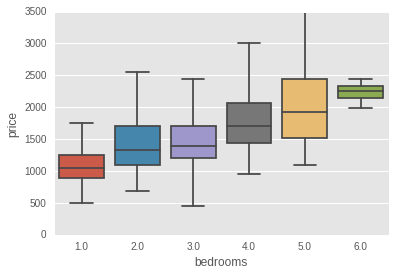

In [29]:
sns.boxplot(data=city_filter_rent, x='bedrooms',y='price',showfliers=False)

In [5]:
threebed=rent_df[rent_df['bedrooms']==3]
latitudes3=[]
longitudes3=[]
prices3=[]
for index, row in threebed.iterrows():
    latitudes3.append(row['latitude'])
    longitudes3.append(row['longitude'])
    prices3.append(row['price'])

We chose to color scale with 10 colors based on the percentile of price within the three bedroom rental subset

In [6]:
import numpy as np
percents=[]
for i in range(10,110,10):
    p=np.percentile(threebed['price'],i)
    percents.append(int(p))
percents

[1000, 1150, 1250, 1350, 1400, 1500, 1600, 1800, 2250, 7000]

In [7]:
scale=['#80b3ff','#66a3ff','#4d94ff','#3385ff','#1a75ff','#0066ff','#005ce6','#0052cc','#0047b3','#003d99']
colors=[]
for index, row in threebed.iterrows():
    if row['price'] <= percents[0]:
        colors.append(scale[0])
    elif row['price'] > percents[0] and row['price'] <= percents[1]:
        colors.append(scale[1])
    elif row['price'] > percents[1] and row['price'] <= percents[2]:
        colors.append(scale[2])
    elif row['price'] > percents[2] and row['price'] <= percents[3]:
        colors.append(scale[3])
    elif row['price'] > percents[3] and row['price'] <= percents[4]:
        colors.append(scale[4])
    elif row['price'] > percents[4] and row['price'] <= percents[5]:
        colors.append(scale[5])
    elif row['price'] > percents[5] and row['price'] <= percents[6]:
        colors.append(scale[6])
    elif row['price'] > percents[6] and row['price'] <= percents[7]:
        colors.append(scale[7])
    elif row['price'] > percents[7] and row['price'] <= percents[8]:
        colors.append(scale[8])
    else:
        colors.append(scale[9])


In [8]:
map_data=zip(latitudes3,longitudes3,prices3,colors)
all_map_data=list(map_data)

map_object = folium.Map(location=[39.29, -76.61], zoom_start=11,tiles='Cartodb Positron')
for i in all_map_data:
    folium.CircleMarker([i[0],i[1]],
        radius=150,
        popup=str(i[2]),
        color=i[3],
        fill_color=i[3],
        ).add_to(map_object)

### Three Bedroom Units, Light to Dark: Lower to Higher Prices

In [9]:
map_object

Obeserved from the map where the geographical pricing differences, particularly the highest prices around the inner harbor and just east of I-83. To further explore geographic price differences, price distrbutions were plotted by zip code.
 

## Exploring Pricing Distributions by Zipcode

In [ ]:
#Short function to sort a given parameter before plotting
def boxplot2_sorted(df, by, column, title):
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values()
    g=sns.boxplot(data=df2[meds.index],showfliers=False)
    sns.plt.title(title)
    for item in g.get_xticklabels():
        item.set_rotation(90)
    return g

In [ ]:
boxplot2_sorted(city_filter_rent, by=["zipcode"], column="price",title="Rental List Price by Zipcode")

In [ ]:
boxplot2_sorted(city_filter_sale, by=["zipcode"], column="price",title="For Sale List Price by Zipcode")

# Adding a variable for distance from the Inner Harbor

In [ ]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
location = geolocator.geocode("inner harbor, baltimore")
print(location.address)
print((location.latitude, location.longitude))

In [ ]:
city_filter_rent['location1'] = list(zip(city_filter_rent.latitude, city_filter_rent.longitude))

In [ ]:
city_filter_rent.count()

In [ ]:
from geopy.distance import vincenty
inner_harbor = (39.2859597, -76.6120432)
total_rows = city_filter_rent.shape[0]
city_filter_rent.loc[:,'Distance'] = [vincenty(inner_harbor, (x)).miles for x in city_filter_rent.loc[:,'location1']]
city_filter_rent.head()

In [ ]:
city_filter_rent.count()

In [ ]:
city_filter_rent.head()

In [ ]:
city_filter_rent.to_csv("rent.csv")

# Preparing Trend Data for Shiny App

In [ ]:
import quandl 

Quandl holds Trulia real estate datebase data. We wanted the median sales price trend data by zip code. Using the naming conventions for this particular report within the database, we were able to iterate through and pull the information for each of our zip codes. We then saved to a csv to use in R. 

In [ ]:
#We use try, except and append the failed zip codes to a seperate list to investigate what data is missing
df2_list=[]
failed=[]
for i in balt_city_zips:
    try:
        df=pd.DataFrame(quandl.get(("ZILL/Z"+i+"_MSP"), authtoken="ew_d4YssE2tQc6fy3N5W"))
        df['Zipcode']=i
        df2_list.append(df)
    except:
        failed.append(i)
        continue
new_df2=pd.concat(df2_list) 

In [ ]:
#new_df2.head()

In [ ]:
failed

 Researching the zipcodes without sales price data, 21203 is a PO box, 21251 a University, and 21287 a specific university building so we would not expect it to have homes. 

In [ ]:
new_df2.to_csv("msp_zip.csv")

In [ ]:
df3_list=[]
failed=[]
for i in balt_city_zips:
    try:
        df=pd.DataFrame(quandl.get(("ZILL/Z"+i+"_PRR"), authtoken="ew_d4YssE2tQc6fy3N5W"))
        df['Zipcode']=i
        df3_list.append(df)
    except:
        failed.append(i)
        continue
new_df3=pd.concat(df3_list)

In [ ]:
new_df3.to_csv("prr.csv")

# Adding a variable for crime rate according to arrest record by zipcode

## After our initial regression anaylsis, we went back to explore further data on crime rates

In [10]:
BPD = pd.read_csv("BPD_Arrest.csv")

In [ ]:
BPD.head()

In [36]:
import numpy as np
BPD.rename(columns = {'Location 1':'Location'}, inplace = True)
BPD = BPD[BPD.Location != '0E-10, 0E-10']
BPD['Location'].replace('', np.nan, inplace = True)
BPD.dropna(subset = ['Location'], inplace = True)

In [37]:
BPD = BPD.reset_index()
del BPD['index']
BPD = BPD.reindex()

In [ ]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
total_rows = len(BPD)
BPD['Location1'] = 'tbd'
for i in range(total_rows):
    location = geolocator.reverse(BPD['Location'][i])
    BPD['Location1'][i] = location.raw['address']['postcode']

In [38]:
BPD.groupby(['Location1'])['Location1'].count().to_csv("crime_frequency.csv")

KeyError: 'Location1'

In [39]:
crime = pd.read_csv("crime_frequency.csv")

In [40]:
population = pd.read_csv("zipcodepopulation.csv")
#Manually collected online and hardcoded into csv

In [41]:
balt_city_zips=['21203','21215','21209','21210','21212','21239','21214','21234','21236','21207','21216','21217','21211','21218','21251','21206','21213','21228','21229','21223','21201','21202','21231','21287','21205','21237','21227','21230','21231','21224','21222','21225','21226']
city_zips=[]
for i in balt_city_zips:
    city_zips.append(int(i))
#filtering the results to only include zips found in Baltimore City
crime=crime[crime['zipcode'].isin(city_zips)]
population=population[population['zipcode'].isin(city_zips)]

In [42]:
crime_population = crime.merge(population, left_on='zipcode', right_on='zipcode', how='inner')

In [ ]:
crime_population

In [43]:
total_rows = len(crime_population)
crime_population['crime_rate'] = 'tbd'
for i in range(total_rows):
    crime_population['crime_rate'][i] = crime_population['crime'][i]/crime_population['population'][i]*10000

/home/zhaorc/.local/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [44]:
crime_population

,zipcode,crime,population,crime_rate
0,21201,67,16972,39.4768
1,21202,88,22832,38.5424
2,21205,96,16146,59.4575
3,21206,65,50846,12.7837
4,21207,11,48133,2.28533
5,21209,4,26465,1.51143
6,21210,1,14292,0.699692
7,21211,12,17351,6.91603
8,21212,35,32322,10.8285
9,21213,168,32733,51.3244


In [45]:
rent_df = pd.read_csv("rent.csv")

In [46]:
rent_df = rent_df.merge(crime_population, left_on='zipcode', right_on='zipcode', how='inner') 

In [47]:
rent_df.to_csv("rent.csv")

In [48]:
sale_crime=city_filter_sale.merge(crime_population,left_on='zipcode', right_on='zipcode', how='inner')

# Predicting Rental Price Based on Regression Analysis

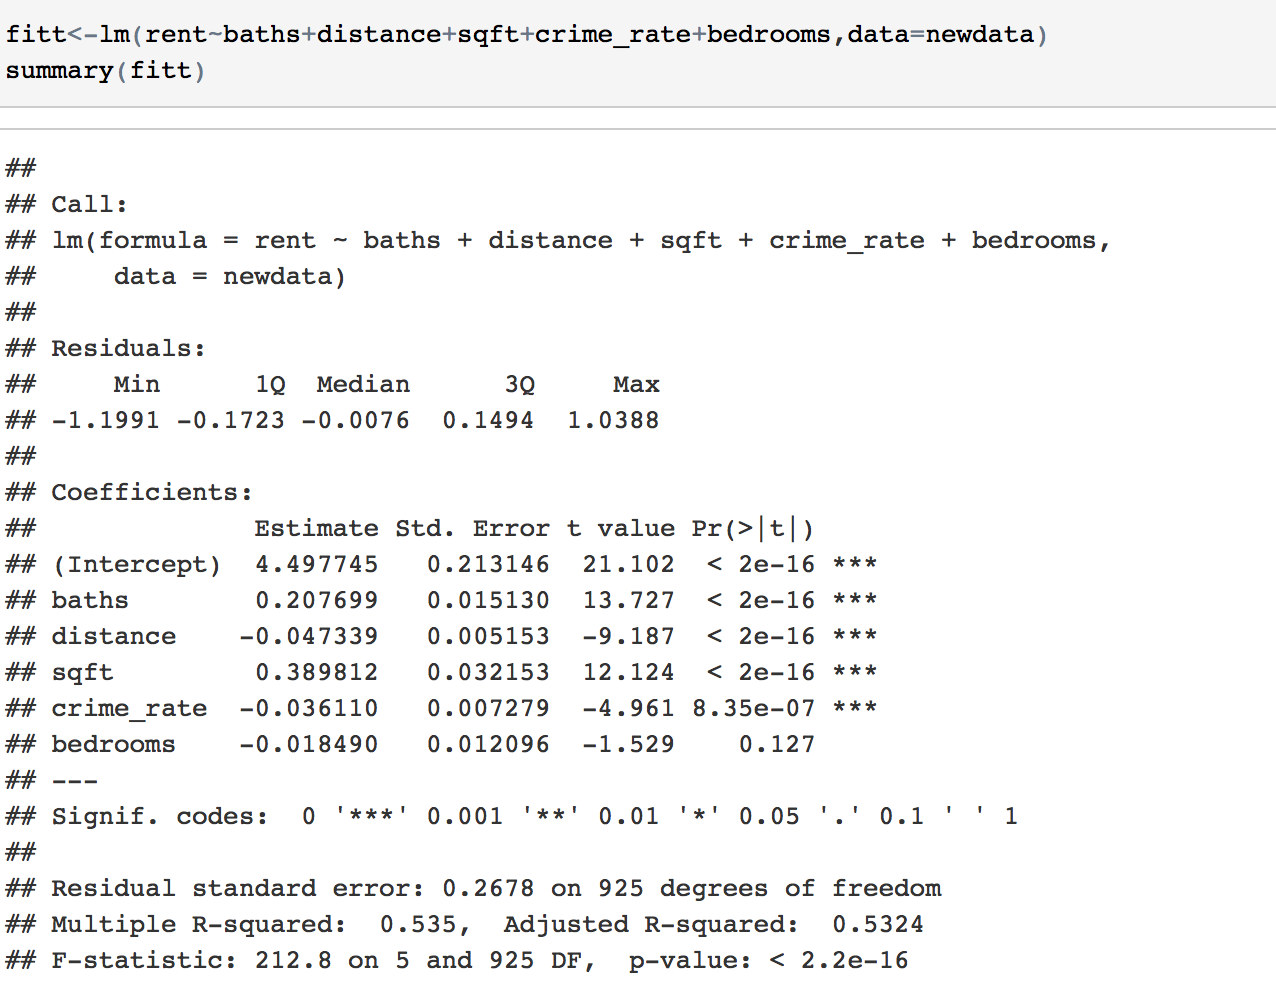

In [8]:
from IPython.display import Image
Image("reg.png")

### Need to filter out properties that are missing data required for our prediction

### And to eliminate some duplicate listings found during data exploration

In [49]:
forpred_df=sale_crime[sale_crime['latitude'].notnull()]
forpred_df=forpred_df[forpred_df['beds'].notnull()]
forpred_df=forpred_df[forpred_df['baths'].notnull()]
forpred_df=forpred_df[forpred_df['crime_rate'].notnull()]
forpred_df=forpred_df[forpred_df['sqft'].notnull()]
forpred_df['crime_rate']=pd.to_numeric(forpred_df['crime_rate'],errors='coerce')
#Investigating the sales data, some of the sales were duplicates, so the frame was cleaned
forpred_df=forpred_df.drop_duplicates()

In [ ]:
forpred_df.count()

In [50]:
#Preparing to add a distance from the Inner Harbor Variable
forpred_df['location1']=list(zip(forpred_df.latitude, forpred_df.longitude))

In [ ]:
forpred_df.head()

In [51]:
from geopy.distance import vincenty
inner_harbor = (39.2859597, -76.6120432)

In [52]:
temp_list=[]
for i in forpred_df.loc[:,'location1']:
    try:
        temp_list.append(vincenty(inner_harbor, i).miles)
    except:
        temp_list.append(0)

In [ ]:
len(temp_list)

In [53]:
forpred_df['distance']=temp_list

The following were included in our final model, although beds was not shown to be a significant variable

In [54]:
intercept=4.497745
bed_coeff=-0.018490
bath_coeff=0.207699
dist_coeff=-0.047339 
sqft_coeff=0.389812
crime_coeff=-0.036110

Sqft and crime_rate were log transformed for our regression model, so new columns were created

In [55]:
import math
forpred_df['sqft_log']= forpred_df['sqft'].apply(lambda x: math.log(x)) 

In [56]:
forpred_df['crime_log']= forpred_df['crime_rate'].apply(lambda x: math.log(x)) 

In [57]:
forpred_df.head()

,address,locality,state,zipcode,latitude,longitude,price,sqft,beds,baths,lot_acres,year_built,crime,population,crime_rate,location1,distance,sqft_log,crime_log
8,3800 Canterbury Rd #A,Baltimore,MD,21218,39.33443,-76.62044,155000.0,965.0,2.0,1.0,NaN,1920,151,49796,30.323721,"(39.33443, -76.62044)",3.373892,6.872128,3.41193
14,306 26th Street,Baltimore,MD,21218,39.31977,-76.61221,129900.0,1496.0,3.0,1.0,0.03,1900,151,49796,30.323721,"(39.31977, -76.61221)",2.332435,7.310550,3.41193
24,1107 Argonne Dr,Baltimore,MD,21218,39.33890,-76.59779,239000.0,2292.0,3.0,2.5,0.13,1936,151,49796,30.323721,"(39.3389, -76.59779)",3.731135,7.737180,3.41193
31,3728 Ellerslie Ave,Baltimore,MD,21218,39.33517,-76.60538,139900.0,1254.0,3.0,1.0,0.05,1927,151,49796,30.323721,"(39.33517, -76.60538)",3.413526,7.134094,3.41193
40,3800 Ednor Rd,Baltimore,MD,21218,39.33414,-76.59954,175000.0,1500.0,4.0,2.0,NaN,1942,151,49796,30.323721,"(39.33414, -76.59954)",3.390612,7.313220,3.41193


In [58]:
import math
forpred_df['pred']=(intercept+bed_coeff*(forpred_df['beds'])+bath_coeff*(forpred_df['baths'])+dist_coeff*(forpred_df['distance'])+sqft_coeff*(forpred_df['sqft_log'])+crime_coeff*(forpred_df['crime_log']))
#Since we log transformed the rent for regression analysis, another calculation is needed to put into dollars
forpred_df['pred_rent']=[math.exp(x) for x in forpred_df.loc[:,'pred']]

In [59]:
forpred_df.head()

,address,locality,state,zipcode,latitude,longitude,price,sqft,beds,baths,...,year_built,crime,population,crime_rate,location1,distance,sqft_log,crime_log,pred,pred_rent
8,3800 Canterbury Rd #A,Baltimore,MD,21218,39.33443,-76.62044,155000.0,965.0,2.0,1.0,...,1920,151,49796,30.323721,"(39.33443, -76.62044)",3.373892,6.872128,3.41193,7.064381,1169.557234
14,306 26th Street,Baltimore,MD,21218,39.31977,-76.61221,129900.0,1496.0,3.0,1.0,...,1900,151,49796,30.323721,"(39.31977, -76.61221)",2.332435,7.310550,3.41193,7.266094,1430.950584
24,1107 Argonne Dr,Baltimore,MD,21218,39.33890,-76.59779,239000.0,2292.0,3.0,2.5,...,1936,151,49796,30.323721,"(39.3389, -76.59779)",3.731135,7.737180,3.41193,7.677735,2159.722758
31,3728 Ellerslie Ave,Baltimore,MD,21218,39.33517,-76.60538,139900.0,1254.0,3.0,1.0,...,1927,151,49796,30.323721,"(39.33517, -76.60538)",3.413526,7.134094,3.41193,7.146132,1269.186743
40,3800 Ednor Rd,Baltimore,MD,21218,39.33414,-76.59954,175000.0,1500.0,4.0,2.0,...,1942,151,49796,30.323721,"(39.33414, -76.59954)",3.390612,7.313220,3.41193,7.406251,1646.243146


In [60]:
forpred_df['rent_ratio']=forpred_df['pred_rent']/forpred_df['price']

In [61]:
forpred_df.sort_values(by='rent_ratio',ascending=False).head()

,address,locality,state,zipcode,latitude,longitude,price,sqft,beds,baths,...,crime,population,crime_rate,location1,distance,sqft_log,crime_log,pred,pred_rent,rent_ratio
91,1920 Christian St,Baltimore,MD,21223,39.28263,-76.64745,8900.0,960.0,3.0,1.0,...,184,26366,69.786847,"(39.28263, -76.64745)",1.912044,6.866933,4.245446,7.082970,1191.501662,0.133877
478,3818 Boarman Ave,Baltimore,MD,21215,39.33468,-76.67975,17400.0,1354.0,5.0,2.5,...,12375,60161,2056.980436,"(39.33468, -76.67975)",4.945931,7.210818,7.628994,7.225788,1374.420774,0.078990
1160,4130 Fairfax Rd,Baltimore,MD,21216,39.32086,-76.68644,16400.0,1200.0,3.0,1.0,...,71,32071,22.138380,"(39.32086, -76.68644)",4.657899,7.090077,3.097313,7.081427,1189.664715,0.072541
472,2609 W Forest Park Ave,Baltimore,MD,21215,39.31933,-76.65946,23100.0,1276.0,3.0,1.0,...,12375,60161,2056.980436,"(39.31933, -76.65946)",3.429027,7.151485,7.628994,6.999899,1096.522584,0.047469
1304,2819 Ganley Drive,Baltimore,MD,21230,39.25584,-76.64346,26000.0,1024.0,3.0,1.0,...,71,33568,21.151096,"(39.25584, -76.64346)",2.674920,6.931472,3.051692,7.115120,1230.431570,0.047324


In [62]:
forpred_df.to_csv("sale_predicted.csv")

# Mapping Top Properties

In [63]:
import numpy as np

In [64]:
forpred_df['rent_ratio'].quantile([.25, .5, .75])

0.25    0.005984
0.50    0.007982
0.75    0.010448
Name: rent_ratio, dtype: float64

In [65]:
percents2=forpred_df['rent_ratio'].quantile([.25, .5, .75]).values

In [76]:
scale=['#e16700','#dda800','#88d500','#46d200']
#scale=['#46d200','#46d200','#46d200','#46d200']
colors2=[]
for index, row in forpred_df.iterrows():
    if row['rent_ratio'] <= percents2[0]:
        colors2.append(scale[0])
    elif row['rent_ratio'] > percents2[0] and row['rent_ratio'] <= percents2[1]:
        colors2.append(scale[1])
    elif row['rent_ratio'] > percents2[1] and row['rent_ratio'] <= percents2[2]:
        colors2.append(scale[2])
    else:
        colors2.append(scale[3])


In [77]:
pred_rent4=[]
latitudes4=[]
longitudes4=[]
prices4=[]
address4=[]
zipcode4=[]
for index, row in forpred_df.iterrows():
    latitudes4.append(row['latitude'])
    longitudes4.append(row['longitude'])
    prices4.append('${:,.2f}'.format(row['price']))
    pred_rent4.append('${:,.2f}'.format(row['pred_rent']))
    address4.append(row['address'])
    zipcode4.append(row['zipcode'])

In [78]:
pop_up_string=list(zip(address4,pred_rent4,prices4,zipcode4))

In [79]:
map_data=zip(latitudes4,longitudes4,pop_up_string,colors2)
all_map_data=list(map_data)

count=0
map_object = folium.Map(location=[39.29, -76.61], zoom_start=11,tiles='Cartodb Positron')
for i in all_map_data:
    folium.CircleMarker([i[0],i[1]],
        radius=130,
        popup=str(i[2]),
        color=i[3],
        fill_color=i[3],
        ).add_to(map_object)
    count+=1
print(count)

421


## The below map shows currently listed properties, color coded by predicted rent over list price. 

### The colors are based on quartiles of the of this predicted rent-to-sales price ratio. The darker green, the higher the ratio. 

### This map allows the investor to find areas of the edge that may signify a future increase in property values for a good investment

In [80]:
map_object